# 1. Set up

## 1.1 libraries

In [1]:
import sys
print("print version")
print(sys.version)

import os
import time
sys.path.insert(1, "/n/data1/hms/sysbio/hormoz/users/sungchul/lib/PY_lib/")
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import re
import subprocess
from PIL import Image
from IPython.display import display
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from functools import wraps

print version
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


## 1.2 variables

In [2]:
path_project = '/n/data1/hms/sysbio/hormoz/users/sungchul/cristea/project_nowak_spatial/'

path_image_cell = f'{path_project}data/image_cell_231019/png_converted/'
path_image_collagen = f'{path_project}data/image_collagen_230904/'

path_df_collagen = f'{path_project}data/df_collagen_231023/'
path_df_collagen_mod = f'{path_project}data/df_collagen_modified_231019/'
vec_filenames_df_collagen = os.listdir(f'{path_df_collagen}')

path_df_cell = f'{path_project}data/df_cell_231023/'

path_map = f'{path_project}data/'
file_map = f'{path_map}core_patient_mapping.csv'

file_df_cell = f'{path_project}data/df_cell.csv'
df_cell = pd.read_csv(file_df_cell)
df_cell['id'] = df_cell['tumor_ids'].astype(str) + '_' + df_cell['core_ids'].astype(str)

path_plot_overlap = f"{path_project}plot/overlap_231030/"
path_plot_overlap_shifted = f"{path_project}plot/overlap_shifted_231030/"
path_df_collagen_modified = f"{path_project}data/df_collagen_modified_231030/"
path_map_leftover = f'{path_project}script/overlay_collagen_cell/'

colormap_scatter = {'cell': 'blue', 'collagen': 'red'}

## 1.3 function

In [3]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        df_split = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'\nFunction <{func.__name__}> Took {total_time:.4f} seconds')
        return df_split
    return timeit_wrapper

def translate_R1(c, min_input, max_input, min_output, max_output):
    return((c - min_input)/(max_input - min_input)*(max_output - min_output) + min_output)

def get_df_map():
    df_map = pd.read_csv(file_map)
    df = df_map

    # Melt the DataFrame
    df_map_melted = pd.melt(df, id_vars = ['TumorID', 'TMA', 'Block_ID_cust', 'Variant'],
                            value_vars = ['Core 1', 'Core 2'], 
                            var_name='CoreType', value_name='Value')

    # Filter out NaN values if desired
    df_map_melted = df_map_melted.dropna(subset = ['Value'])

    # Rename CoreType values for clarity
    df_map_melted['CoreType'] = df_map_melted['CoreType'].str.replace(' ', '')
    df_map_melted = df_map_melted.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    #df_map_melted['CoreID'] = df_map_melted['Block_ID_cust'].astype(str) + ',' + df_map_melted['Value'].astype(str)
    df_map_melted['CoreID'] = '1,' + df_map_melted['Value'].astype(str)
    df_map_melted['CoreID_modified'] = (df_map_melted['TMA'].astype(str) + '.' + 
                                        df_map_melted['Variant'].astype(str) + '_' + 
                                        df_map_melted['CoreID'].astype(str))
    df_map_melted = df_map_melted[['TumorID', 'CoreID_modified']]
    return(df_map_melted)

def get_filename(index_image):
    for index_temp, row in df_filenames_png[['key_PNG', 'filename']].iloc[(index_image):(index_image + 1)].iterrows():
        i = row['key_PNG']
        df_match = df_map_melted[df_map_melted['CoreID_modified'] == i]
        
        if (df_match.shape[0] == 0):
            print(f'<get_filename> WARNING: no match for {i}; skip')
            pass
        elif (df_match.shape[0] != 1):
            print(f'<get_filename> ERROR: more than one match')
        else:
            print(f'<get_filename> SUCCESS: one match for {i}')
            i_tumor_id, i_core_id = df_match[['TumorID', 'CoreID_modified']].iloc[0].values
            i_filename_cell = row['filename']
            i_filename_collagen = re.sub(r"_phenotype_map-\d+", "", i_filename_cell)
            i_filename_output = f'{i_tumor_id}_{i_core_id}'
            return(i_filename_cell, i_filename_collagen, i_filename_output)

def fn_image_to_df(file_image):
    colourImg = Image.open(file_image)
    colourPixels = colourImg.convert("RGB")
    colourArray = np.array(colourPixels.getdata()).reshape(colourImg.size + (3,))
    indicesArray = np.moveaxis(np.indices(colourImg.size), 0, 2)
    allArray = np.dstack((indicesArray, colourArray)).reshape((-1, 5))
    df = pd.DataFrame(allArray, columns=["y", "x", "red","green","blue"])
    df_subset = df[~((df['red'] == 255) & (df['green'] == 255) & (df['blue'] == 255))]
    return(colourImg, df_subset)
    
def fn_reconstruct(df, img = None, bool_color_white = True, 
                   bool_save = False, 
                   path_save = None,
                   name_plot = None
                  ):
    if img == None:
        reconstructed_img = np.zeros((max(df['x']) + 1, max(df['y']) + 1, 3), dtype=np.uint8)
        print(f"<fn_reconstruct> image size: {max(df['x']) + 1, max(df['y']) + 1}")

    else:
        reconstructed_img = np.zeros((img.size[1], img.size[0], 3), dtype=np.uint8)
        print(f'<fn_reconstruct> image size: {img.size[1], img.size[0]}')
        
    if (bool_color_white):
        reconstructed_img[df['x'].values, df['y'].values] = [255, 255, 255]
    else:
        reconstructed_img[df['x'].values, df['y'].values] = df[['red', 'green', 'blue']].values
    plt.imshow(reconstructed_img)
    plt.show()
    if (bool_save):
        # save plot in path_save as name_plot.png
        file_path = os.path.join(path_save, f"{name_plot}.png")
        plt.savefig(file_path)
    plt.close() 
    
def fn_image_to_df(file_image):
    colourImg = Image.open(file_image)
    colourPixels = colourImg.convert("RGB")
    colourArray = np.array(colourPixels.getdata())
    
    # Get image dimensions
    width, height = colourImg.size
    
    # Reshape colourArray to (height, width, 3)
    colourArray = colourArray.reshape((height, width, 3))
    
    # Create an array with indices
    indicesArray = np.moveaxis(np.indices((height, width)), 0, 2)
    
    # Flatten the arrays and concatenate them
    allArray = np.dstack((indicesArray, colourArray)).reshape((-1, 5))
    
    df = pd.DataFrame(allArray, columns=["y", "x", "red", "green", "blue"])
    df_subset = df[~((df['red'] == 255) & (df['green'] == 255) & (df['blue'] == 255))]
    return colourImg, df_subset

def save_df(df, filename_output, TYPE = None):
    if TYPE == 'collagen':
        file_df_collagen = f'{path_df_collagen}{filename_output}.tsv'
        df.to_csv(file_df_collagen, sep = '\t', index = None)
    elif TYPE == 'cell':
        file_df_cell = f'{path_df_cell}{filename_output}.tsv'
        df.to_csv(file_df_cell, sep = '\t', index = None)
    else:
        print(f'<save_df> ERROR: TYPE must be collagen or cell')
        
# get a dataframe df_filenames_png which has 
def fn_get_df_filenames_png(path_image_cell):
    filenames_png = os.listdir(path_image_cell)

    # Regex pattern to capture the required portions of the filename
    pattern = r"HTMA_(\d{3})\.(\d)_Core\[(\d+,\d+,\d+)\]"

    # Lists to store the extracted values
    three_digits = []
    single_digit = []
    comma_separated_digits = []

    # Iterate through each filename and extract the desired information
    for filename in filenames_png:
        match = re.search(pattern, filename)
        if match:
            three_digits.append(match.group(1))
            single_digit.append(match.group(2))
            comma_separated_digits.append(match.group(3))
        else:
            print('no match for:', filename)

    # Convert the lists to a DataFrame
    df_filenames_png = pd.DataFrame({
        'ThreeDigits': three_digits,
        'SingleDigit': single_digit,
        'CommaSeparatedDigits': comma_separated_digits
    })

    # Create 'key_PNG' column by combining the captured patterns
    df_filenames_png['key_PNG'] = (df_filenames_png['ThreeDigits'].astype(str) + 
                                   '.' + 
                                   df_filenames_png['SingleDigit'].astype(str) + 
                                   '_' + 
                                   df_filenames_png['CommaSeparatedDigits'].astype(str))
    df_filenames_png['filename'] = filenames_png

    return(df_filenames_png)

# Create a DataFrame from the list of filenames
def fn_create_df_map(df_cell, path_df_cell, path_df_collagen, df_filenames_png):
    df_image_cell_files = pd.DataFrame({'file_cell': os.listdir(path_df_cell)})
    df_image_cell_files['file_cell'] = df_image_cell_files['file_cell'].str.replace('.tsv$', '', regex=True)

    df_image_collagen_files = pd.DataFrame({'file_collagen': os.listdir(path_df_collagen)})
    df_image_collagen_files['file_collagen'] = df_image_collagen_files['file_collagen'].str.replace('.tsv$', '', regex=True)

    df_map = pd.merge(
        pd.merge(df_cell[['id', 'core_ids']].drop_duplicates(), 
                 df_image_cell_files, 
                 how = 'left', left_on = 'id', right_on = 'file_cell'), 
        df_image_collagen_files,
        how = 'left', left_on = 'id', right_on = 'file_collagen')
    df_map_temp = pd.merge(
        df_map,
        df_filenames_png[['key_PNG', 'filename']],
        how = 'left', left_on = 'core_ids', right_on = 'key_PNG'
    )

    df_map_temp['filename_cell'] = df_map_temp['filename']
    df_map_temp['filename_collagen'] = df_map_temp['filename'].str.replace('_phenotype_map-14.png', '.png', regex=True)
    df_map_temp.drop('filename', axis = 1, inplace = True)
    return(df_map_temp)

def create_pixel_offset_tuples(width, height):
    
    if (width > 2408) or (height > 2408):
        print(f"<create_pixel_offset_tuples> wrong width and height: {width} {height}")
        
    # Subtracting 2409 from A and B
    n_pixel_offset_x = 2409 - width
    n_pixel_offset_y = 2409 - height
    
    # Creating vec_offset_x and vec_offset_y arrays
    vec_offset_x = np.arange(n_pixel_offset_x)
    vec_offset_y = np.arange(n_pixel_offset_y)
    
    # Creating all combinations of pairs from vec_offset_x and vec_offset_y
    pixel_pairs = [(x, y) for x in vec_offset_x for y in vec_offset_y]
    
    # Creating a dictionary with tuples as keys and empty values
    pixel_dict = {pair: None for pair in pixel_pairs}
    
    return pixel_dict

def count_overlap(df1, df2):
    df_merge_temp = pd.merge(df1[['x', 'y']], df2[['x', 'y']], 
                             how = 'outer', left_on = ['x', 'y'], right_on = ['x', 'y'], indicator = True)
    return(sum(df_merge_temp['_merge'] == 'both'))

def compute_overlap(keys_subset, df_image_collagen, df_image_cell):
    result = []
    for keys in keys_subset:
        x, y = keys
        df_temp = pd.DataFrame({'x': df_image_collagen['x'] + x, 'y': df_image_collagen['y'] + y})
        overlap = count_overlap(df_image_cell, df_temp)
        result.append((keys, overlap))
    return result

@timeit
def parallel_compute_overlap(dict_offset, df_image_collagen, df_image_cell, num_splits=10):
    print(f'<parallel_compute_overlap> trying {len(dict_offset.keys())} combinations')
    
    # Convert the keys to a NumPy array for proper splitting
    keys_array = np.array(list(dict_offset.keys()), dtype=object)

    # Splitting the keys for parallel processing
    keys_split = np.array_split(keys_array, num_splits)
    
    # Creating partial function
    partial_func = partial(compute_overlap, df_image_collagen=df_image_collagen, df_image_cell=df_image_cell)
    
    # Using ProcessPoolExecutor for parallel processing
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(partial_func, keys_split))
    
    # Updating dict_offset with results
    for subset in results:
        for keys, overlap in subset:
            dict_offset[tuple(keys)] = overlap
        
    return dict_offset

def transform_df_image_collagen(df_image_collagen, df_image_cell, df_cell_subset, 
                                bool_save = False, 
                                path_save = path_df_collagen_modified,
                                name_df = None
                               ):
    min_x_cell_image = min(df_image_cell['x'])
    max_x_cell_image = max(df_image_cell['x'])
    min_y_cell_image = min(df_image_cell['y'])
    max_y_cell_image = max(df_image_cell['y'])

    min_x_cell_df = min(df_cell_subset['X'])
    max_x_cell_df = max(df_cell_subset['X'])
    min_y_cell_df = min(df_cell_subset['Y'])
    max_y_cell_df = max(df_cell_subset['Y'])

    df_image_collagen['y_trans'] = df_image_collagen['y'].apply(
        lambda c: translate_R1(c, min_y_cell_image, max_y_cell_image, min_y_cell_df, max_y_cell_df)
    )

    df_image_collagen['x_trans'] = df_image_collagen['x'].apply(
        lambda c: translate_R1(c, min_x_cell_image, max_x_cell_image, min_x_cell_df, max_x_cell_df)
    )

    df_image_collagen_mod = df_image_collagen[['x_trans', 'y_trans']]
    df_image_collagen_mod.columns = ['x', 'y']

    if (bool_save):
        file_df_image_collagen_mod = f'{path_save}{name_df}.tsv'
        df_image_collagen_mod[['x', 'y']].to_csv(file_df_image_collagen_mod, index = False, sep = '\t')
    return(df_image_collagen_mod)

@timeit
def fn_align(index_core, df_map):
    row = df_map.iloc[index_core]
    ID = row['id']
    
    print(f'<fn_align> starting with index: {index_core}, ID: {ID}')
    
    filename_df_image_collagen = f"{path_df_collagen}{ID}.tsv"
    filename_df_image_cell = f"{path_df_cell}{ID}.tsv"
    filename_image_collagen = f"{path_image_collagen}{row['filename_collagen']}"

    file_paths = [filename_df_image_collagen, filename_df_image_cell, filename_image_collagen]

    # Checking if all files exist
    if not(all(os.path.isfile(path) for path in file_paths)):
        print(f"<fn_align > some files don't exist for {ID}")
        pass

    df_cell_subset = df_cell[df_cell['id'] == ID]
    df_image_collagen = pd.read_csv(filename_df_image_collagen, sep = '\t')[['x', 'y']]
    df_image_cell = pd.read_csv(filename_df_image_cell, sep = '\t')[['x', 'y']]
    image_collagen = Image.open(filename_image_collagen)

    width, height = image_collagen.size

    if (width == height == 2408):
        pass
    else:
        # Usage example
        dict_offset = create_pixel_offset_tuples(width, height)
        print(f'<fn_align> image_collagen size: {width} x {height}')
        
        updated_dict_offset = parallel_compute_overlap(dict_offset, df_image_collagen, df_image_cell)

        key_with_highest_value = max(updated_dict_offset, key=updated_dict_offset.get)
        print(f"<fn_align> key with highest value {key_with_highest_value}")

        x, y = key_with_highest_value

        df_image_collagen['x'] = df_image_collagen['x'] + x
        df_image_collagen['y'] = df_image_collagen['y'] + y

    df_image_collagen[['red', 'green', 'blue']] = [255, 0, 0]
    df_image_cell[['red', 'green', 'blue']] = [255, 255, 255]

    df_temp = pd.concat([df_image_collagen, df_image_cell], axis = 0)
    fn_reconstruct(df_temp, bool_color_white = False, bool_save = True,
                  path_save = path_plot_overlap, name_plot = ID)

    df_image_collagen_modified = transform_df_image_collagen(
        df_image_collagen, df_image_cell, df_cell_subset, 
        bool_save = True, path_save = path_df_collagen_modified, name_df = ID)
    
    df_cell_subset_temp = df_cell_subset[['X', 'Y']].copy()
    df_cell_subset_temp.columns = ['x', 'y']
    df_cell_subset_temp['type'] = 'cell'
    df_image_collagen_modified = df_image_collagen_modified.copy()
    df_image_collagen_modified['type'] = 'collagen'
    
    df_temp = pd.concat([df_image_collagen_modified, df_cell_subset_temp], axis = 0)
    colors = df_temp['type'].map(colormap_scatter)
    plt.scatter(df_temp['x'], df_temp['y'], color = colors)
    plt.savefig(f'{path_plot_overlap_shifted}{ID}.png')
    plt.show()
    
# update df_map to only include leftover jobs that were not completed due to timeout
def update_map(df_map, vec_completed, bool_save = False, path_save = None, name_df = None):
    # vec_completed is pd.Series
    # df_map is the pandas dataframe
    df_map_temp = pd.merge(df_map, pd.DataFrame({'file_plot': vec_completed}),
                           how = 'left', left_on = 'id', right_on = 'file_plot')
    
    # subset rows without match
    result = df_map_temp[df_map_temp['file_plot'].isna()].copy()
    
    # drop file_plot column
    result.drop('file_plot', axis = 1, inplace = True)
    
    if (bool_save):
        result.to_csv(f'{path_save}{name_df}.tsv', sep = '\t', index = False)
    
    return(result)

# main

In [4]:
df_map_melted = get_df_map()
df_filenames_png = fn_get_df_filenames_png(path_image_cell)
df_map = fn_create_df_map(df_cell, path_df_cell, path_df_collagen, df_filenames_png)

starting index 13
<fn_align> starting with index: 13, ID: PANT0018_300.1_1,2,4
<fn_align> image_collagen size: 2408 x 2372
<parallel_compute_overlap> trying 37 combinations

Function <parallel_compute_overlap> Took 49.2899 seconds
<fn_align> key with highest value (0, 4)
<fn_reconstruct> image size: (2408, 2376)


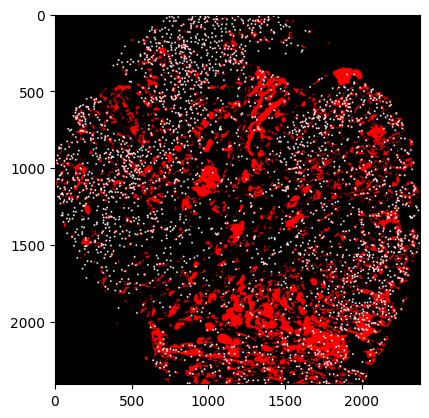

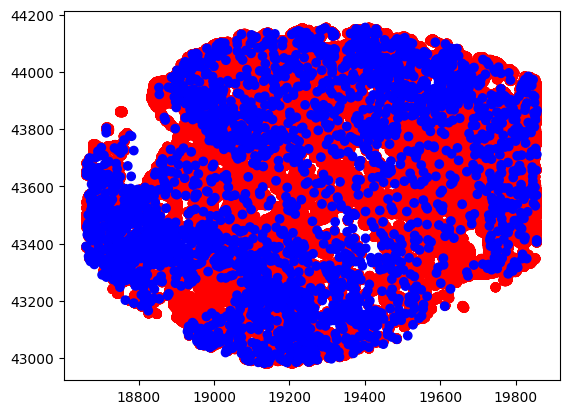


Function <fn_align> Took 134.3917 seconds


In [5]:
for i in range(13, 14):
    print(f"starting index {i}")
    fn_align(i, df_map)

# main (with leftovers)

In [ ]:
df_map_melted = get_df_map()
df_filenames_png = fn_get_df_filenames_png(path_image_cell)
df_map = fn_create_df_map(df_cell, path_df_cell, path_df_collagen, df_filenames_png)

In [6]:
vec_completed_jobs_231101 = pd.Series(os.listdir(path_plot_overlap_shifted)).str.replace('.png', '', regex=True)
df_map_updated_231101 = update_map(df_map, vec_completed_jobs_231101, bool_save = True, 
                                   path_save = path_map_leftover, name_df = 'df_map_leftover_231101')

df_map_updated_231101 = pd.read_csv(f'{path_map_leftover}df_map_leftover_231101.tsv', sep = '\t')

In [48]:
for i in range(13, 14):
    print(f"starting index {i}")
    fn_align(i, df_map_updated_231031)

starting index 13
<fn_align> starting with index: 13, ID: ROCH0003_372.2_1,4,1
<fn_align> image_collagen size: 2244 x 2204
<fn_align> trying 33825 combinations


Process ForkProcess-267:
Process ForkProcess-273:
Process ForkProcess-274:
Process ForkProcess-280:
Process ForkProcess-268:
Process ForkProcess-287:
Process ForkProcess-286:
Process ForkProcess-279:
Process ForkProcess-284:
Process ForkProcess-278:
Process ForkProcess-272:
Process ForkProcess-270:
Process ForkProcess-269:
Process ForkProcess-288:
Process ForkProcess-275:
Process ForkProcess-285:
Process ForkProcess-282:
Process ForkProcess-281:
Process ForkProcess-276:
Process ForkProcess-271:
Process ForkProcess-277:
Process ForkProcess-283:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call la

  File "/n/app/python/3.7.4/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/n/app/python/3.7.4/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/n/app/python/3.7.4/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/n/app/python/3.7.4/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/n/app/python/3.7.4/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/n/app/python/3.7.4/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/n/app/python/3.7.4/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_

KeyboardInterrupt: 